In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import pandas as pd
import glob

In [114]:
N_steps = 1000
kappa = 0.6
kappastr = f"{kappa:.2f}"
L = 32
R = 1000 
mode = "t"
modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"

dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
filepattern = f"emcx_data_*"
files = glob.glob(f"{dirpath}/{filepattern}")

In [115]:
def getObs(fname, qty_number):
    df = pd.read_csv(fname)
    betas = df["Beta"]
    header = list(df)[qty_number]
    observable = df[header]
    obs_interp = make_interp_spline(betas,observable,k=3)

    beta_model = np.linspace(0.1,2,N_steps)
    obs_model = obs_interp(beta_model)
    return obs_model

def getlastFE(fname):
    df = pd.read_csv(fname)
    betas = df["Beta"]
    FE = -1*df["Free Energy"]/df["Beta"] # need to manipulate F a little, based on what is calculated in C++
    
    FE_interp = make_interp_spline(betas,FE,k=3)
    beta_model = np.linspace(0.1,2.5,N_steps)
    FE_model = FE_interp(beta_model)
    return FE_model[-200]

In [116]:
beta_model = np.linspace(0.1,2.5,N_steps)
obs_array = np.empty(shape = (len(files),N_steps))
FE_array = np.empty(len(files))
quantity = 11
for i in range(len(files)):
    obs_array[i] = getObs(files[i],quantity)
    FE_array[i] = getlastFE(files[i])

obs_means = np.empty(N_steps)
obs_stds = np.empty(N_steps)
for i in range(N_steps):
    obs_means[i] = np.mean(obs_array[:,i])
    obs_stds[i] = np.std(obs_array[:,i])

FE_mean = np.mean(FE_array)
FE_std = np.std(FE_array)
# print(f"<F> = {FE_mean} +/- {FE_std}")

# plt.errorbar(beta_model, obs_means, obs_stds)
# plt.show()

In [117]:
def getErrorBarPlot(kappa,L,R,mode, quantity): ## This might be depreciated as these are not weighted averages
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    # beta_model = np.linspace(0.1,2.5,N_steps)
    obs_array = np.empty(shape = (len(files),N_steps))
    FE_array = np.empty(len(files))
    for i in range(len(files)):
        obs_array[i] = getObs(files[i],quantity)
        FE_array[i] = getlastFE(files[i])

    obs_means = np.empty(N_steps)
    obs_stds = np.empty(N_steps)
    for i in range(N_steps):
        obs_means[i] = np.mean(obs_array[:,i])
        obs_stds[i] = np.std(obs_array[:,i])

    return obs_means, obs_stds

In [118]:
def compareQuantity(kappa,L,R,quantity):
    kappastr = f"{kappa:.2f}"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/Two-Replica_Method/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    filepattern_2 = f"param_info_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    df = pd.read_csv(files[0])
    # p_info = np.loadtxt(glob.glob(f"{dirpath}/{filepattern_2}")[0])
    header = list(df)[quantity]

    t_means, t_stds = getErrorBarPlot(kappa = kappa,L = L, R = R,mode = "t", quantity = quantity)
    p_means, p_stds = getErrorBarPlot(kappa = kappa,L = L, R = R,mode = "p", quantity = quantity)
    beta_vals = np.linspace(0.1,2.5,N_steps)
    
    
    plt.errorbar(beta_vals, t_means, t_stds, marker = '.', markersize = 0.5, color = 'b', label = "Two Replica", linewidth = 0)
    plt.errorbar(beta_vals, p_means, p_stds, marker = '.', markersize = 0.5, color = 'r', label = "Wolff", linewidth = 0)
    plt.errorbar(beta_vals, t_means, t_stds, color = 'b', linewidth = 0.5, alpha = 0.5)
    plt.errorbar(beta_vals, p_means, p_stds, color = 'r', linewidth = 0.5, alpha = 0.5)
    plt.legend()
    plt.title(f"Average over {len(files)} runs for {header}\n"\
              + f"L = {L}, R = {R}, " + r"$\kappa$" + f" = {kappa}")
    plt.show()

In [119]:
def getMeanFE(kappa,L,R,mode):
    kappastr = f"{kappa:.2f}"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    # beta_model = np.linspace(0.1,2.5,N_steps)
    FE_array = np.empty(len(files))
    for i in range(len(files)):
        FE_array[i] = getlastFE(files[i])/(L*L)


    FE_mean = np.mean(FE_array)
    FE_std = np.std(FE_array)
    # print(f"<F> = {FE_mean} +/- {FE_std}")

    return FE_mean, FE_std

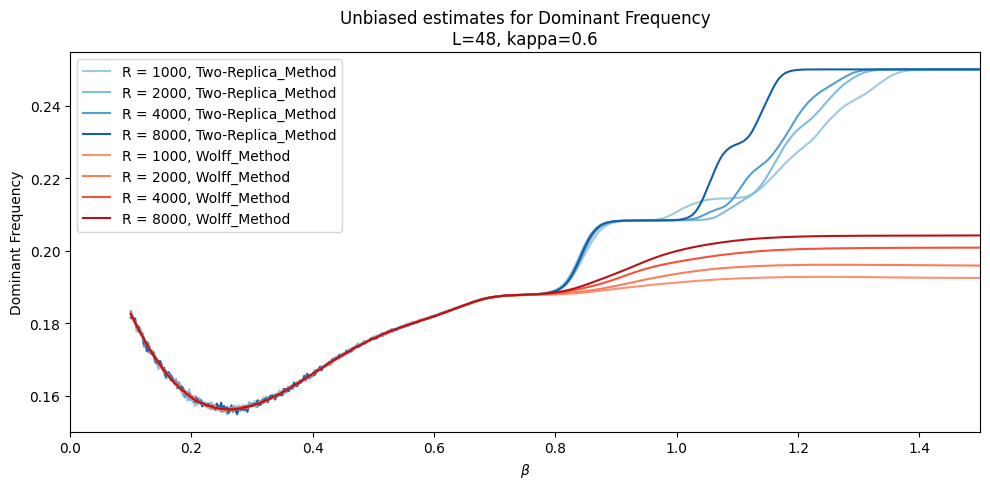

In [185]:
""" FIX THIS BAD BOY """
def getUnbiasedEstimate(kappa,L,R,mode,quantity):
    kappastr = f"{kappa:.2f}"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    beta_model = np.linspace(0.1,2.5,N_steps)   
    df_example = pd.read_csv(files[0])
    header = list(df_example)[quantity]

    observables = np.zeros(shape = (len(files), N_steps))
    FE_weights = np.zeros(shape = (len(files), N_steps))
    FE_weight_denoms = np.zeros(shape = N_steps)

    for i in range(len(files)):
        df = pd.read_csv(files[i])
        betas = df["Beta"]
        observable = df[header]
        FE = df["Free Energy"]/(L*L) ### DIVIDE BY NUMBER OF SPINS TO MAKE NUMBERS MANAGEABLE
        obs_spline = make_interp_spline(betas, observable, k=3)
       
        FE_spline = make_interp_spline(betas, FE, k=3)
        obs_interp = obs_spline(beta_model)
        observables[i,:] = obs_interp
        FE_interp = FE_spline(beta_model)
        for j in range(N_steps):
            FE_weights[i,j] = np.exp(FE_interp[j])
            FE_weight_denoms[j] += np.exp(FE_interp[j])
    
    for i in range(N_steps):
        FE_weights[:,i] /= FE_weight_denoms[i]
    
    unbiased_obs = np.zeros(N_steps)
    for i in range(len(files)):
        unbiased_obs += observables[i,:] * FE_weights[i,:]
    cmap = plt.colormaps.get_cmap('Blues') if mode == "t" else plt.colormaps.get_cmap('Reds')
    colors = cmap(np.linspace(0, 1, 16000))
    plt.plot(beta_model, unbiased_obs, label = f"R = {R}, {modestr}", color = colors[R+5000])
    plt.title(f"Unbiased estimates for {header}\nL={L}, kappa={kappa}")
    plt.xlim(0,1.5)
    plt.ylabel(f"{header}")
    plt.xlabel(r"$\beta$")

comparer = 11
plt.figure(figsize = (10,5))
L_test = 48
getUnbiasedEstimate(kappa=0.6,L = L_test,R=1000,mode="t",quantity=comparer)
getUnbiasedEstimate(kappa=0.6,L = L_test,R=2000,mode="t",quantity=comparer)
getUnbiasedEstimate(kappa=0.6,L = L_test,R=4000,mode="t",quantity=comparer)
getUnbiasedEstimate(kappa=0.6,L = L_test,R=8000,mode="t",quantity=comparer)
# getUnbiasedEstimate(kappa=0.6,L = L_test,R=16000,mode="t",quantity=comparer)
getUnbiasedEstimate(kappa=0.6,L = L_test,R=1000,mode="p",quantity=comparer)
getUnbiasedEstimate(kappa=0.6,L = L_test,R=2000,mode="p",quantity=comparer)
getUnbiasedEstimate(kappa=0.6,L = L_test,R=4000,mode="p",quantity=comparer)
getUnbiasedEstimate(kappa=0.6,L = L_test,R=8000,mode="p",quantity=comparer)
# getUnbiasedEstimate(kappa=0.6,L = L_test,R=16000,mode="p",quantity=comparer)
plt.legend()
plt.tight_layout()
plt.show()


In [181]:
### FIX THIS

def getUnbiasedFE(kappa,L,R,mode):
    kappastr = f"{kappa:.2f}"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    beta_model = np.linspace(0.1,2.5,N_steps)   
    FE_interp_vals = np.empty(shape = (len(files), N_steps))
    unbiased_FE = np.empty(N_steps)
    for i in range(len(files)):
        df = pd.read_csv(files[i])
        betas = df["Beta"]
        FE = df["Free Energy"]/(L*L) # need to manipulate F a little, based on what is calculated in C++
        FE_interp = make_interp_spline(betas,FE,k=3)
        FE_model = FE_interp(beta_model)
        FE_interp_vals[i,:] = FE_model
    
    for i in range(N_steps):
        unbiased_FE[i] = np.log((1/len(files))*np.sum(np.exp(FE_interp_vals[:,i])))
        unbiased_FE[i] *= -1/beta_model[i]
        unbiased_FE[i]
    return unbiased_FE

In [122]:
def getProbFindGS(kappa,L,R,quantity):
    kappastr = f"{kappa:.2f}"
    dirpath_t = f"/Users/shanekeiser/Downloads/production-run/Two-Replica_Method/{kappastr}_kappa/{L}_L/{R}_R"
    dirpath_w = f"/Users/shanekeiser/Downloads/production-run/Wolff_Method/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    filepattern_2 = f"param_info_*"
    files_t = glob.glob(f"{dirpath_t}/{filepattern}")
    files_w = glob.glob(f"{dirpath_w}/{filepattern}")
    df_t = pd.read_csv(files_t[0])
    df_w = pd.read_csv(files_w[0])
    # p_info = np.loadtxt(glob.glob(f"{dirpath}/{filepattern_2}")[0])
    header = list(df_t)[quantity]

    final_val = 0 # Placeholder

    if quantity == 11 and kappa > 0.5: # Which other quantities can we use?
        final_val = 0.25

    gs_found_counter_t = 0
    gs_found_counter_w = 0
    obs_array_t = np.empty(shape = (len(files)))
    obs_array_w = np.empty(shape = (len(files)))

    for i in range(len(files)):
        obs_array_t[i] = getObs(files_t[i],quantity)[-1]
        if np.abs(obs_array_t[i] - final_val) < 1e-4: # 1e-4 tolerance
            gs_found_counter_t += 1
        obs_array_w[i] = getObs(files_w[i],quantity)[-1]
        if np.abs(obs_array_w[i] - final_val) < 1e-4: # 1e-4 tolerance
            gs_found_counter_w += 1
    
    prob_t = gs_found_counter_t/len(files)
    prob_w = gs_found_counter_w/len(files)
    
    print("Probability to reach f = 0.25 (Dominant frequency)")
    print(f"R = {R}, L = {L}, kappa = {kappa}")
    print(f"For TR: {prob_t} | For Wolff: {prob_w}")



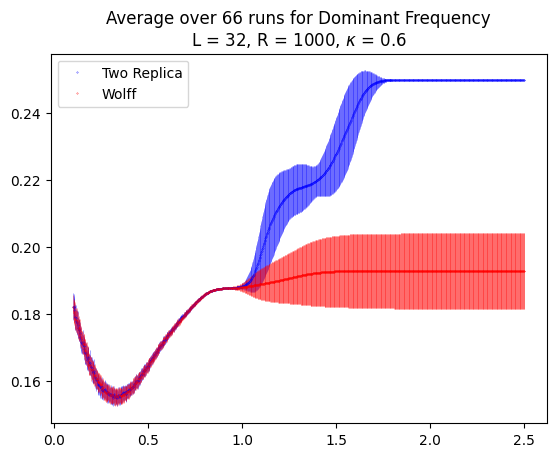

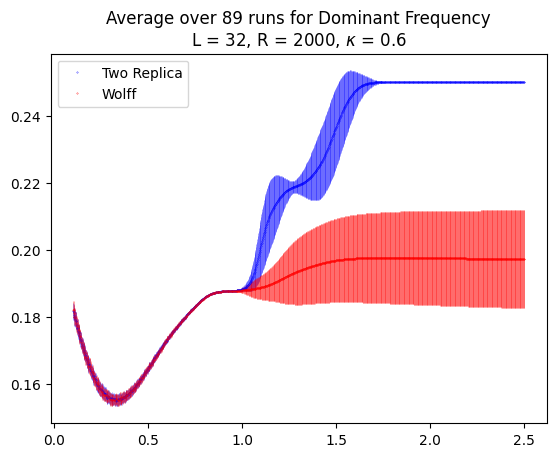

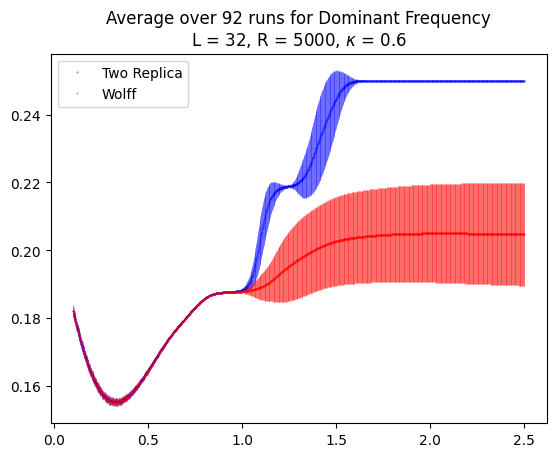

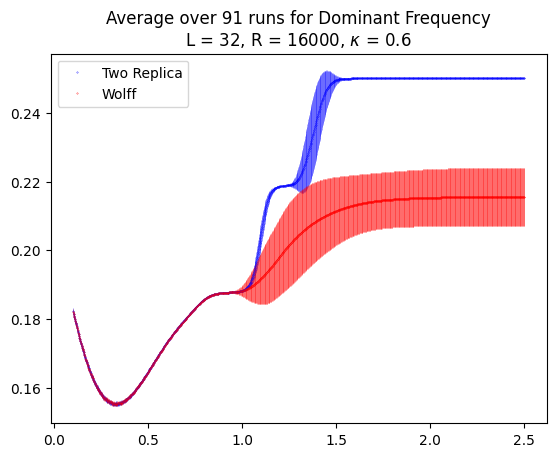

Probability to reach f = 0.25 (Dominant frequency)
R = 1000, L = 32, kappa = 0.6
For TR: 1.0 | For Wolff: 0.0
Probability to reach f = 0.25 (Dominant frequency)
R = 2000, L = 32, kappa = 0.6
For TR: 1.0 | For Wolff: 0.0
Probability to reach f = 0.25 (Dominant frequency)
R = 5000, L = 32, kappa = 0.6
For TR: 1.0 | For Wolff: 0.0
Probability to reach f = 0.25 (Dominant frequency)
R = 16000, L = 32, kappa = 0.6
For TR: 1.0 | For Wolff: 0.0


In [123]:
# Using some earlier functions

comparer = 11
compareQuantity(kappa = 0.6, L = 32, R = 1000, quantity = comparer)
compareQuantity(kappa = 0.6, L = 32, R = 2000, quantity = comparer)
compareQuantity(kappa = 0.6, L = 32, R = 5000, quantity = comparer)
compareQuantity(kappa = 0.6, L = 32, R = 16000, quantity = comparer)

getProbFindGS(kappa=0.6,L=32,R=1000,quantity=11)
getProbFindGS(kappa=0.6,L=32,R=2000,quantity=11)
getProbFindGS(kappa=0.6,L=32,R=5000,quantity=11)
getProbFindGS(kappa=0.6,L=32,R=16000,quantity=11)

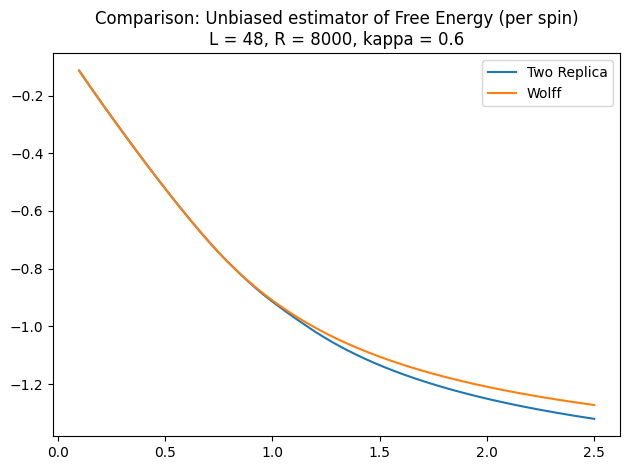

In [186]:
# Unbiased Estimator of FE

kappa_uFE = 0.6
L_uFE = 48
R_uFE = 8000
unbiased_FE_t = getUnbiasedFE(kappa = 0.6, L = L_uFE, R = R_uFE, mode = "t")
unbiased_FE_p = getUnbiasedFE(kappa = 0.6, L = L_uFE, R = R_uFE, mode = "p")

plt.plot(beta_model, unbiased_FE_t, label = "Two Replica")
plt.plot(beta_model, unbiased_FE_p, label = "Wolff")
plt.title("Comparison: Unbiased estimator of Free Energy (per spin)" + f"\nL = {L_uFE}, R = {R_uFE}, kappa = {kappa_uFE}")
plt.legend()
plt.tight_layout()
plt.show()



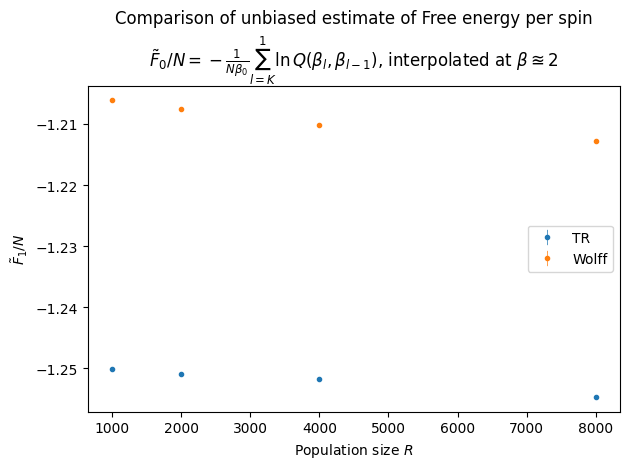

In [187]:
# Compare FE over the two methods and R
R_vals = np.array([1000,2000,4000,8000])
L_val = 48
t_FE_stats = np.empty(shape = (len(R_vals), 2))
p_FE_stats = np.empty(shape = (len(R_vals), 2))

for i in range(len(R_vals)):
#     t_FE_stats[i,:] = getMeanFE(kappa = 0.6, L = 32, R = R_vals[i], mode = "t")
#     p_FE_stats[i,:] = getMeanFE(kappa = 0.6, L = 32, R = R_vals[i], mode = "p")
    t_FE_stats[i,0] = getUnbiasedFE(kappa = 0.6, L = L_val, R = R_vals[i], mode = "t")[-200]
    t_FE_stats[i,1] = 0 ### Get error by using bootstrap method
    p_FE_stats[i,0] = getUnbiasedFE(kappa = 0.6, L = L_val, R = R_vals[i], mode = "p")[-200]
    p_FE_stats[i,1] = 0


plt.errorbar(R_vals, t_FE_stats[:,0], t_FE_stats[:,1], marker = '.', label = "TR", elinewidth = 0.5, linewidth = 0, capsize = 0.2)
plt.errorbar(R_vals, p_FE_stats[:,0], p_FE_stats[:,1], marker = '.', label = "Wolff", elinewidth = 0.5, linewidth = 0, capsize = 0.2)
plt.legend()
plt.title(f"Comparison of unbiased estimate of Free energy per spin\n" + r"$\tilde{F}_{0}/N = - \frac{1}{N\beta_0} \sum_{l=K}^{1} \ln Q(\beta_l, \beta_{l-1})$, interpolated at $\beta \approxeq 2$")
plt.xlabel(r"Population size $R$")
plt.ylabel(r"$\tilde{F}_{1}/N$")
plt.tight_layout()
plt.show()


In [146]:
### Get rho_F (R * Var(beta * F))

def getRhoF(kappa,L,R,mode):
    kappastr = f"{kappa:.2f}"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    # beta_model = np.linspace(0.1,2.5,N_steps)
    FE_array = np.empty(shape = (len(files), N_steps))

    for i in range(len(files)):
        df = pd.read_csv(files[i])
        betas = df["Beta"]
        FE = df["Free Energy"]
        FE_interp = make_interp_spline(betas,FE,k=3)
        beta_model = np.linspace(0.1,2.5,N_steps)
        FE_array[i,:] = FE_interp(beta_model)

    var_FE = np.zeros(N_steps)
    rho_FE = np.zeros(N_steps)
    std_error_FE = np.zeros(N_steps)
    for j in range(N_steps):
        var_FE[j] = np.std(FE_array[:,j])**2
        rho_FE[j] = R*var_FE[j]
        std_error_FE[j] = (1/np.sqrt(len(files)))*np.std(FE_array[:,j])
    plt.plot(beta_model, rho_FE, label = f"R = {R}")
    return rho_FE

def getSE_FE(kappa,L,R,mode):
    kappastr = f"{kappa:.2f}"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    # beta_model = np.linspace(0.1,2.5,N_steps)
    FE_array = np.empty(shape = (len(files), N_steps))

    for i in range(len(files)):
        df = pd.read_csv(files[i])
        betas = df["Beta"]
        FE = df["Free Energy"]
        FE_interp = make_interp_spline(betas,FE,k=3)
        beta_model = np.linspace(0.1,2.5,N_steps)
        FE_array[i,:] = FE_interp(beta_model)

    var_FE = np.zeros(N_steps)
    rho_FE = np.zeros(N_steps)
    std_error_FE = np.zeros(N_steps)
    for j in range(N_steps):
        var_FE[j] = np.std(FE_array[:,j])**2
        rho_FE[j] = R*var_FE[j]
        std_error_FE[j] = (1/np.sqrt(len(files)))*np.std(FE_array[:,j])
    plt.plot(beta_model, std_error_FE, label = f"R = {R}")
    return std_error_FE

def getVarF(kappa,L,R,mode):
    kappastr = f"{kappa:.2f}"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    # beta_model = np.linspace(0.1,2.5,N_steps)
    FE_array = np.empty(shape = (len(files), N_steps))
    beta_model = np.linspace(0.1,2.5,N_steps)
    for i in range(len(files)):
        df = pd.read_csv(files[i])
        betas = df["Beta"]
        FE = df["Free Energy"]
        FE_interp = make_interp_spline(betas,FE,k=3)
        FE_array[i,:] = FE_interp(beta_model)

    var_FE = np.zeros(N_steps)
    rho_FE = np.zeros(N_steps)
    std_error_FE = np.zeros(N_steps)
    for j in range(N_steps):
        var_FE[j] = np.std(FE_array[:,j])**2
        rho_FE[j] = R*var_FE[j]
        std_error_FE[j] = (1/np.sqrt(len(files)))*np.std(FE_array[:,j])

    plt.plot(beta_model, var_FE, label = f"R = {R}")
    return var_FE



    

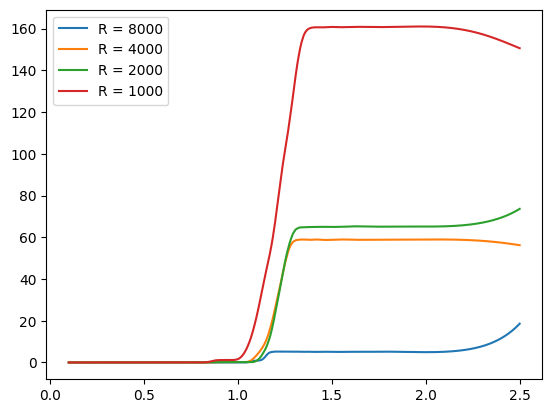

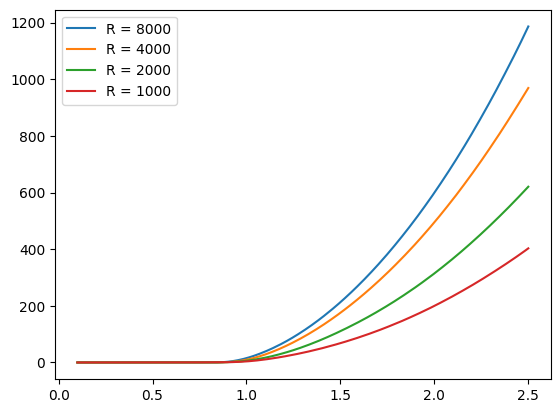

In [189]:
L_val = 48

# varF_t_1 = getVarF(kappa=0.6,L=L_val,R=16000,mode="t")
varF_t_2 = getVarF(kappa=0.6,L=L_val,R=8000,mode="t")
varF_t_3 = getVarF(kappa=0.6,L=L_val,R=4000,mode="t")
varF_t_4 = getVarF(kappa=0.6,L=L_val,R=2000,mode="t")
varF_t_5 = getVarF(kappa=0.6,L=L_val,R=1000,mode="t")
plt.legend()
plt.show()

# varF_p_1 = getVarF(kappa=0.6,L=L_val,R=16000,mode="p")
varF_p_2 = getVarF(kappa=0.6,L=L_val,R=8000,mode="p")
varF_p_3 = getVarF(kappa=0.6,L=L_val,R=4000,mode="p")
varF_p_4 = getVarF(kappa=0.6,L=L_val,R=2000,mode="p")
varF_p_5 = getVarF(kappa=0.6,L=L_val,R=1000,mode="p")
plt.legend()
plt.show()

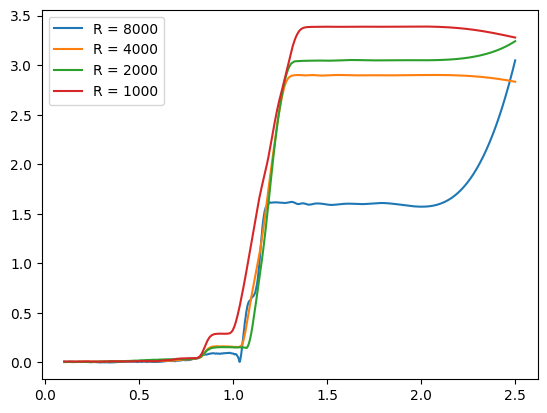

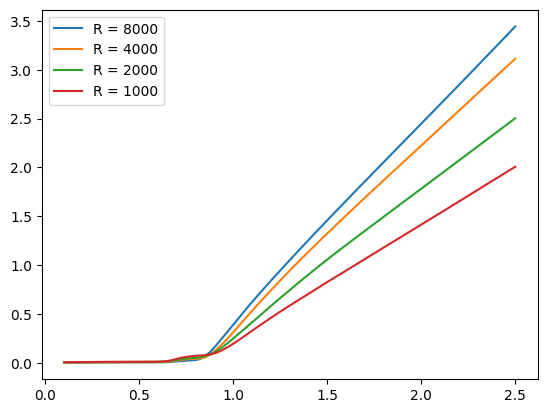

In [319]:
L_val = 48

# varF_t_1 = getSE_FE(kappa=0.6,L=L_val,R=16000,mode="t")
varF_t_2 = getSE_FE(kappa=0.6,L=L_val,R=8000,mode="t")
varF_t_3 = getSE_FE(kappa=0.6,L=L_val,R=4000,mode="t")
varF_t_4 = getSE_FE(kappa=0.6,L=L_val,R=2000,mode="t")
varF_t_5 = getSE_FE(kappa=0.6,L=L_val,R=1000,mode="t")
plt.legend()
plt.show()

# varF_p_1 = getSE_FE(kappa=0.6,L=L_val,R=16000,mode="p")
varF_p_2 = getSE_FE(kappa=0.6,L=L_val,R=8000,mode="p")
varF_p_3 = getSE_FE(kappa=0.6,L=L_val,R=4000,mode="p")
varF_p_4 = getSE_FE(kappa=0.6,L=L_val,R=2000,mode="p")
varF_p_5 = getSE_FE(kappa=0.6,L=L_val,R=1000,mode="p")
plt.legend()
plt.show()

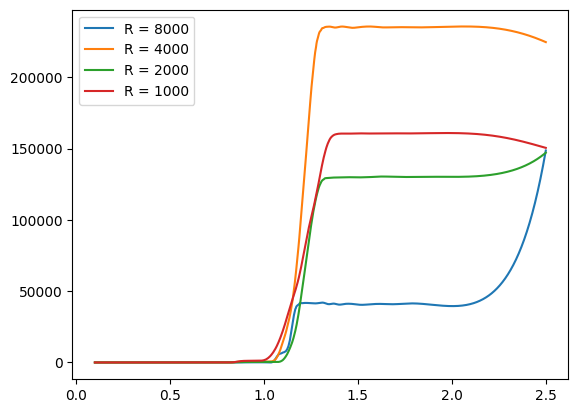

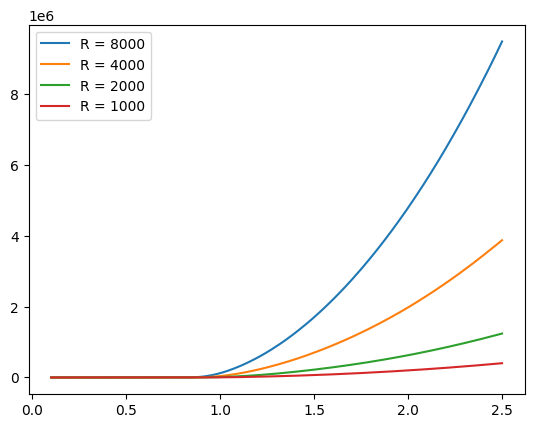

In [193]:
L_val = 48

# varF_t_1 = getRhoF(kappa=0.6,L=L_val,R=16000,mode="t")
varF_t_2 = getRhoF(kappa=0.6,L=L_val,R=8000,mode="t")
varF_t_3 = getRhoF(kappa=0.6,L=L_val,R=4000,mode="t")
varF_t_4 = getRhoF(kappa=0.6,L=L_val,R=2000,mode="t")
varF_t_5 = getRhoF(kappa=0.6,L=L_val,R=1000,mode="t")
plt.legend()
plt.show()

# varF_p_1 = getRhoF(kappa=0.6,L=L_val,R=16000,mode="p")
varF_p_2 = getRhoF(kappa=0.6,L=L_val,R=8000,mode="p")
varF_p_3 = getRhoF(kappa=0.6,L=L_val,R=4000,mode="p")
varF_p_4 = getRhoF(kappa=0.6,L=L_val,R=2000,mode="p")
varF_p_5 = getRhoF(kappa=0.6,L=L_val,R=1000,mode="p")
plt.legend()
plt.show()

/var/folders/fk/md7wtpb54yb3hp5d33lb9v200000gn/T/ipykernel_72646/4073323221.py:19: RuntimeWarning: overflow encountered in exp
  unbiased_FE[i] = np.log((1/len(files))*np.sum(np.exp(FE_interp_vals[:,i])))


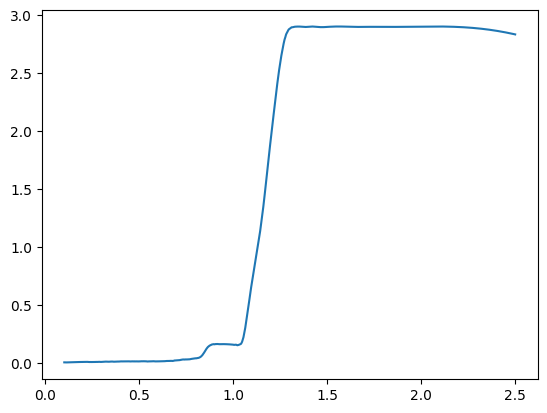

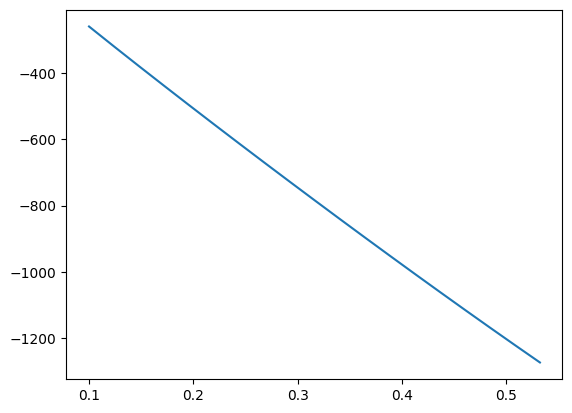

In [318]:
kappa_uFE = 0.6
L_uFE = 48
R_uFE = 4000
unbiased_FE_t = getUnbiasedFE(kappa = kappa_uFE, L = L_uFE, R = R_uFE, mode = "t")
se_F_t = getSE_FE(kappa = kappa_uFE, L = L_uFE, R = R_uFE, mode="t")
plt.show()


plt.errorbar(beta_model[::10], unbiased_FE_t[::10], se_F_t[::10]) # Plot every 10th value
plt.show()

In [621]:
from scipy.stats import bootstrap

### Let's start from the beginning, shall we?

N_steps = 1000
beta_model = np.linspace(0.1,2.5,N_steps)


dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
filepattern = f"emcx_data_*"
files = glob.glob(f"{dirpath}/{filepattern}")

def getUnbiasedEstimate(kappa,L,R,mode,quantity):
    # This function returns the unbiased estimator for an observable, as well as its standard error which is found using the bootstrap method.
    kappastr = f"{kappa:.2f}"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    beta_model = np.linspace(0.1,2.5,N_steps)   
    df_example = pd.read_csv(files[0])
    header = list(df_example)[quantity]

    if quantity != 18: # and quantity != 6:

        obs_matrix = np.zeros(shape = (len(files), N_steps))
        FE_weights = np.zeros(shape = (len(files), N_steps))
        FE_weight_denoms = np.zeros(shape = N_steps)
        FE_interp = np.zeros(shape = (len(files), N_steps))

        for i in range(len(files)):
            df = pd.read_csv(files[i])
            df.drop(df.tail(4).index,inplace=True)
            betas = np.array(df["Beta"])
            observable = df[header]
            FE = df["Free Energy"] ### DIVIDE BY NUMBER OF SPINS TO MAKE NUMBERS MANAGEABLE --> Is this even OK to do? probably yes just to get weightings
            # print(FE)
            obs_spline = make_interp_spline(betas, observable, k=3)
            FE_spline = make_interp_spline(betas, FE, k=3)
            obs_interp = obs_spline(beta_model)
            obs_matrix[i,:] = obs_interp
            FE_interp[i,:] = FE_spline(beta_model)
            for j in range(N_steps):
                FE_weights[i,j] = np.exp(FE_interp[i,j] - max(FE_interp[:,j]))
                FE_weight_denoms[j] += FE_weights[i,j]
        # print(FE_weights[50,:])
    
        for i in range(N_steps):
            FE_weights[:,i] /= FE_weight_denoms[i]
        
        unbiased_obs = np.zeros(N_steps)
        for i in range(len(files)):
            unbiased_obs += obs_matrix[i,:] * FE_weights[i,:]
        
    # if quantity == 6:

    #     ene_matrix = np.zeros(shape = (len(files), N_steps))
    #     ene_sq_matrix = np.zeros(shape = (len(files), N_steps))
    #     obs_matrix = np.zeros(shape = (len(files), N_steps))
    #     FE_weights = np.zeros(shape = (len(files), N_steps))
    #     FE_weight_denoms = np.zeros(shape = N_steps)
    #     FE_interp = np.zeros(shape = (len(files), N_steps))
    #     for i in range(len(files)):
    #         df = pd.read_csv(files[i])
    #         betas = np.array(df["Beta"])
    #         energy = df["Energy"]
    #         energy_sq = df["Energy Squared"]
    #         FE = df["Free Energy"] ### DIVIDE BY NUMBER OF SPINS TO MAKE NUMBERS MANAGEABLE --> Is this even OK to do? probably yes just to get weightings
    #         # print(FE)
    #         ene_spline = make_interp_spline(betas, energy, k=3)
    #         ene_sq_spline = make_interp_spline(betas, energy_sq, k=3)
    #         FE_spline = make_interp_spline(betas, FE, k=3)
    #         ene_interp = ene_spline(beta_model)
    #         ene_sq_interp = ene_sq_spline(beta_model)
    #         ene_matrix[i,:] = ene_interp
    #         ene_sq_matrix[i,:] = ene_sq_interp
    #         obs_matrix[i,:] = (ene_sq_interp - (ene_interp*L)**2)*beta_model**2
    #         FE_interp[i,:] = FE_spline(beta_model)

    #         for j in range(N_steps):
    #             FE_weights[i,j] = np.exp(FE_interp[i,j] - max(FE_interp[:,j]))
    #             FE_weight_denoms[j] += FE_weights[i,j]
    
    #     for i in range(N_steps):
    #         FE_weights[:,i] /= FE_weight_denoms[i]
        
    #     unbiased_obs = np.zeros(N_steps)
    #     unbiased_ene = np.zeros(N_steps)
    #     unbiased_ene_sq = np.zeros(N_steps)
    #     for i in range(len(files)):
    #         unbiased_ene += ene_matrix[i,:] * FE_weights[i,:]
    #         unbiased_ene_sq += ene_sq_matrix[i,:] * FE_weights[i,:]
            
    #     unbiased_obs = (unbiased_ene_sq - (unbiased_ene*L)**2)*beta_model**2
        

    ### Bootstrap method
    B = len(files)
    N_samples = B

    bootstrap_obs = np.zeros(shape = (B,N_steps))
    se_obs_bootstrap = np.zeros(shape = N_steps)

    for i in range(B):
        for j in range(N_steps):
            for k in range(N_samples):
                r = np.random.randint(0,len(files))
                bootstrap_obs[i,j] += obs_matrix[r,j]
    bootstrap_obs /= N_samples

    # print(bootstrap_obs)
    for i in range(N_steps):
        se_obs_bootstrap[i] = np.sqrt((np.std(bootstrap_obs[:,i])**2)/(B-1))
    print(B)
    return unbiased_obs, se_obs_bootstrap


 

Specific Heat
91
91


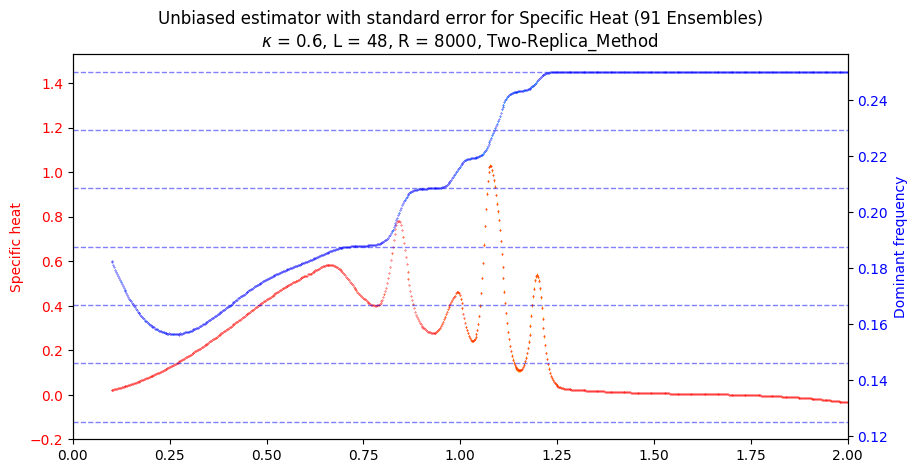

In [624]:
### Comparing specific heat and dominant frequency  

kappa = 0.6
kappastr = f"{kappa:.2f}"
L = 48
R =  8000
mode = "t"
modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
quantity = 6
df_example = pd.read_csv(files[0])
header = list(df_example)[quantity]
print(header)


# unbiased_obs_1, se_obs_1 = getUnbiasedEstimate(kappa = kappa, L = L, R = 1000, mode = mode, quantity = quantity)
# unbiased_obs_2, se_obs_2 = getUnbiasedEstimate(kappa = kappa, L = L, R = 2000, mode = mode, quantity = quantity)
unbiased_obs_3, se_obs_3 = getUnbiasedEstimate(kappa = kappa, L = L, R = R, mode = mode, quantity = 6)
unbiased_obs_4, se_obs_4 = getUnbiasedEstimate(kappa = kappa, L = L, R = R, mode = mode, quantity = 11)
# unbiased_obs_5, se_obs_5 = getUnbiasedEstimate(kappa = kappa, L = L, R = 16000, mode = mode, quantity = quantity)
# print(se_obs_1)


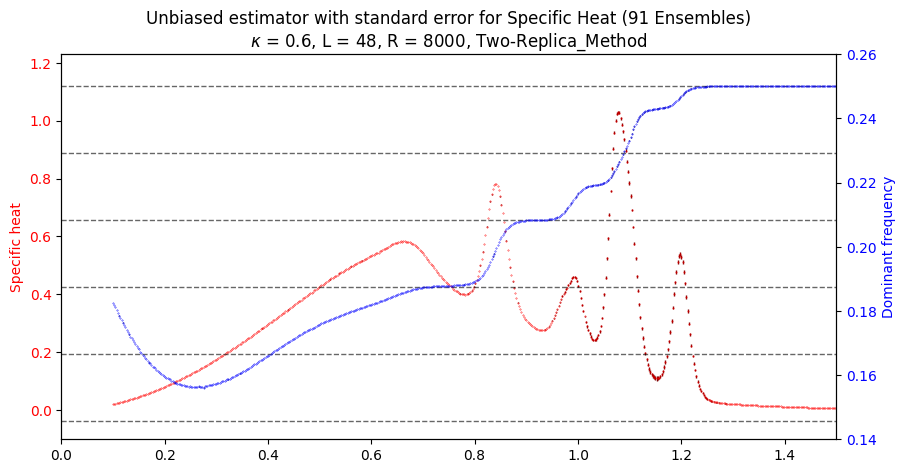

In [637]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.errorbar(beta_model, unbiased_obs_3, se_obs_3, linewidth = 0, elinewidth = 1, marker = '.', markersize = 0.6, color = "red", ecolor = "maroon")
ax1.set_ylabel("Specific heat", color = "red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_ylim(-0.1,max(unbiased_obs_3)+0.2)
ax2 = ax1.twinx()
ax2.errorbar(beta_model, unbiased_obs_4, se_obs_4, linewidth = 0, elinewidth = 1, marker = '.', markersize = 0.6, color = "blue", ecolor = "navy")
ax2.hlines(y = np.arange(((L/4)-(L/8))/L, ((L/4)+1)/L, 1/L), xmin = 0, xmax = 2.5, linewidth = 1, linestyle = 'dashed', alpha = 0.6, color = "black")
ax2.set_ylabel("Dominant frequency", color = "blue")
ax2.set_ylim(0.14,0.26)
ax2.tick_params(axis='y', labelcolor="blue")
plt.title(f"Unbiased estimator with standard error for {header} (91 Ensembles)\n" + rf"$\kappa$ = {kappa}, L = {L}, R = {R}, {modestr}")
# ax1.text(x = 0.1, y = 1.6, s = "Specific heat using\nvariance re-weighting scheme", bbox = dict(facecolor='red', alpha=0.5))
plt.xlim(0,1.5)
plt.show()

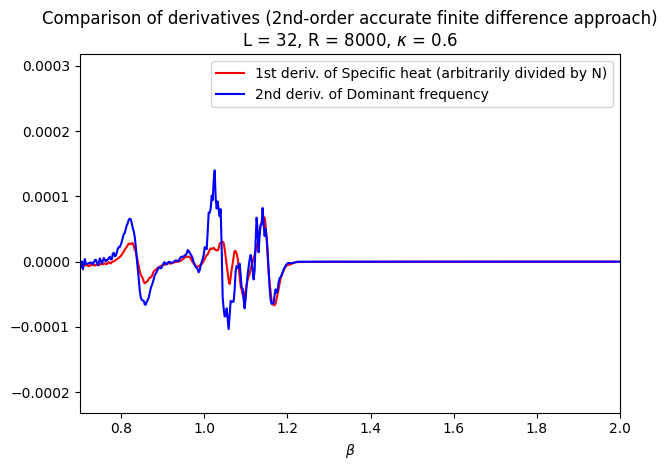

In [535]:
# Plot between different derivatives
plt.plot(beta_model, np.gradient(unbiased_obs_3)/(32*32), color = 'r', label = '1st deriv. of Specific heat (arbitrarily divided by N)')
#ax2 = ax1.twiny()
plt.plot(beta_model, np.gradient(np.gradient(unbiased_obs_4)), color = 'b', label = '2nd deriv. of Dominant frequency')
plt.legend()
plt.title("Comparison of derivatives (2nd-order accurate finite difference approach)\n" + r"L = 32, R = 8000, $\kappa$ = 0.6")
plt.xlabel(r"$\beta$")
plt.tight_layout()
plt.xlim(0.7,2)
plt.show()

In [617]:
def getUnbiasedFE(kappa,L,R,mode):
    kappastr = f"{kappa:.2f}"
    modestr = "Two-Replica_Method" if (mode == "t") else "Wolff_Method"
    dirpath = f"/Users/shanekeiser/Downloads/production-run/{modestr}/{kappastr}_kappa/{L}_L/{R}_R"
    filepattern = f"emcx_data_*"
    files = glob.glob(f"{dirpath}/{filepattern}")
    beta_model = np.linspace(0.1,2.5,N_steps)   
    FE_interp_vals = np.empty(shape = (len(files), N_steps))
    unbiased_FE = np.empty(N_steps)
    for i in range(len(files)):
        # print(files[i])
        df = pd.read_csv(files[i])
        betas = df["Beta"][:-3]
        FE = df["Free Energy"][:-3] # need to manipulate F a little, based on what is calculated in C++
        FE_interp = make_interp_spline(betas,FE,k=3)
        FE_model = FE_interp(beta_model)
        FE_interp_vals[i,:] = FE_model
    
    for i in range(N_steps):
        # unbiased_FE[i] = np.log((1/len(files))*np.sum(np.exp(FE_interp_vals[:,i]))) # Has overflow from too large numbers
        unbiased_FE[i] = -np.log(len(files)) + np.max(FE_interp_vals[:,i]) + np.log(np.sum(np.exp(FE_interp_vals[:,i] - np.max(FE_interp_vals[:,i]))))
        unbiased_FE[i] *= -1/beta_model[i]
        unbiased_FE[i]

    ### Bootstrap method
    B = len(files)
    print(B)
    N_samples = 30

    bootstrap_obs = np.zeros(shape = (B,N_steps))
    se_obs_bootstrap = np.zeros(shape = N_steps)

    for i in range(B):
        for j in range(N_steps):
            for k in range(N_samples):
                r = np.random.randint(0,len(files))
                bootstrap_obs[i,j] += FE_interp_vals[r,j]
    bootstrap_obs /= N_samples

    # print(bootstrap_obs)
    for i in range(N_steps):
        se_obs_bootstrap[i] = np.sqrt((np.std(bootstrap_obs[:,i])**2)/(B-1))
    # print(B)
    return unbiased_FE, se_obs_bootstrap





In [618]:
kappa_FE = 0.6
L_FE = 48
R_FE = 4000
ue_FE_1, se_FE_1 = getUnbiasedFE(kappa = kappa_FE, L = L_FE, R = R_FE, mode = "t")
ue_FE_2, se_FE_2 = getUnbiasedFE(kappa = kappa_FE, L = L_FE, R = R_FE, mode = "p")

137
200


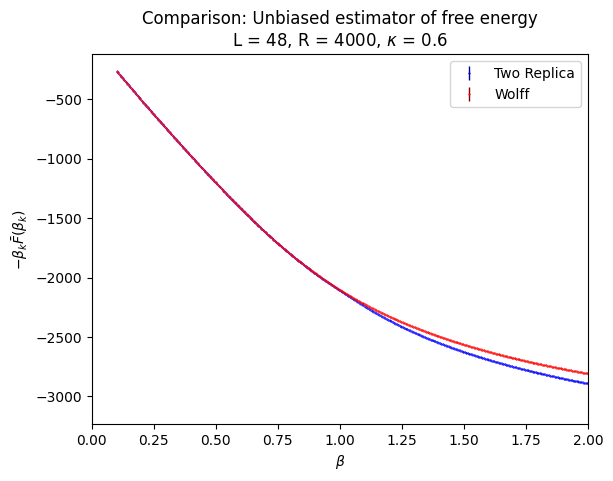

In [640]:
plt.errorbar(beta_model, ue_FE_1, se_FE_1, marker = '.', linewidth = 0, elinewidth = 1, markersize = 0.6, color = 'b', ecolor = 'navy', label = "Two Replica")
plt.errorbar(beta_model, ue_FE_2, se_FE_2, marker = '.', linewidth = 0, elinewidth = 1, markersize = 0.6, color = 'r', ecolor = 'maroon', label = "Wolff")
plt.xlim(0,2)
plt.legend(markerscale = 2)
plt.title(f"Comparison: Unbiased estimator of free energy\nL = {L_FE}, R = {R_FE}, " + r"$\kappa$ = " + f"{kappa_FE}")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$-\beta_k \bar{F}(\beta_k)$")
plt.show()